# Step 1: Description of Problem and data

The goal of this challenge is to use generative methods, particularly Generative Adversarial Networks (GANs), to create a set of 10,000 64x64 RGB images of dogs. The images cannot be altered versions of existing dog images or previously classified dog photos.

The data includes the Stanford Dogs Dataset, which contains a large collection of dog images for training purposes.

The zip files are as follows:
* all-dogs.zip: this is all dog images of different sizes
* annotations.zip: class labels and bounding boxes

In [1]:
#  importing libraries and data
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np, pandas as pd, os
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt, zipfile 
from PIL import Image

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization, Conv2DTranspose
from keras.callbacks import LearningRateScheduler
from keras import optimizers

from IPython.display import FileLink, FileLinks
from PIL import Image
import IPython.display as display

2024-04-29 01:34:19.034227: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 01:34:19.034308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 01:34:19.035934: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import zipfile

with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as all_dogs:
    all_dogs.extractall("/kaggle/temp/")
    
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as annotation:
    annotation.extractall("/kaggle/temp/")

In [3]:
root = '/kaggle/temp/'
annotation = os.listdir(root + 'Annotation') 
all_dogs = os.listdir(root + 'all-dogs')

In [4]:
print(f'There are {len(all_dogs)} files in all-dogs folder.')
print(f'There are {len(annotation)} files files in Annotation folder.')

There are 20579 files in all-dogs folder.
There are 120 files files in Annotation folder.


# Step 2: Exploratory Data Analysis (EDA) — Inspect, Visualize and Clean the Data

The next step is to crop the images in order to use them in the model. All images after the crop will be different sizes. Please note that the cropping method below is not my own. I will be referring to the cropping method found in this link: https://www.kaggle.com/code/aligsaoud/dog-image-generator

In [5]:
idxIn = 0; 
namesIn = []
img_size = 32
imagesIn = np.zeros((25000, img_size, img_size, 3))
DogsOnly = False

# CROP WITH BOUNDING BOXES TO GET DOGS ONLY
if DogsOnly:
    for breed in breeds:
        for dog in os.listdir(ROOT + 'annotation/Annotation/' + breed):
            try: 
                img = Image.open(ROOT + 'all-dogs/' + dog +'.jpg') 
            except: 
                continue           
            tree = ET.parse(ROOT + 'annotation/Annotation/' + breed + '/' + dog)
            root = tree.getroot()
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                w = np.min((xmax - xmin, ymax - ymin))
                img2 = img.crop((xmin, ymin, xmin + w, ymin + w))
                img2 = img2.resize((img_size, img_size), Image.ANTIALIAS)
                imagesIn[idxIn, :, :, :] = np.asarray(img2)
                namesIn.append(breed)
                idxIn += 1
                
# RANDOMLY CROP FULL IMAGES
else:
    x = np.random.choice(np.arange(20000), 10000)
    for k in range(len(x)):
        img = Image.open(root + 'all-dogs/' + all_dogs[x[k]])
        w = img.size[0]
        h = img.size[1]
        if (k % 2 == 0) | (k % 3 == 0):
            w2 = 100
            h2 = int(h / (w / 100))
            a = 18
            b = 0          
        else:
            a = 0
            b=0
            if w < h:
                w2 = img_size
                h2 = int((img_size / w) * h)
                b = (h2 - img_size)//2
            else:
                h2 = img_size
                w2 = int((img_size / h) * w)
                a = (w2 - img_size)//2
        img = img.resize((w2, h2), Image.ANTIALIAS)
        img = img.crop((0 + a, 0 + b, img_size + a, img_size + b))  
        imagesIn[idxIn, :, :, :] = np.asarray(img)
        namesIn.append(all_dogs[x[k]])
        idxIn += 1

/tmp/ipykernel_444/3750077187.py:54: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((w2, h2), Image.ANTIALIAS)


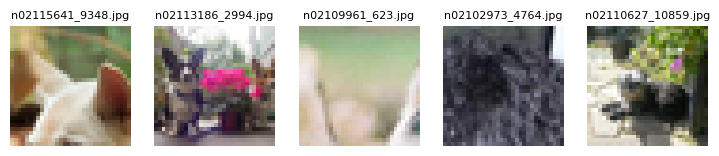

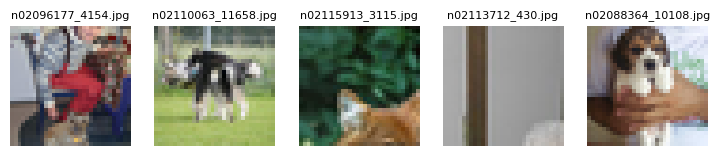

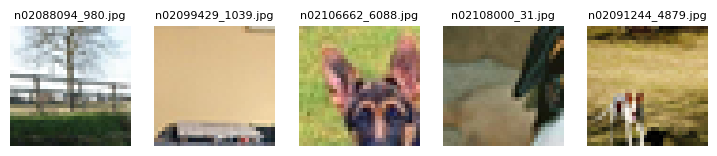

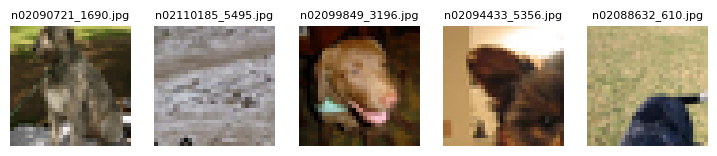

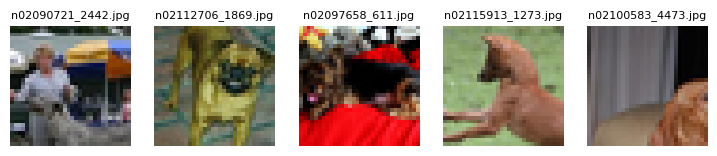

In [6]:
# DISPLAY CROPPED IMAGES
x = np.random.randint(0, idxIn, 25)
for k in range(5):
    plt.figure(figsize=(9,3))
    for j in range(5):
        plt.subplot(1, 5, j + 1)
        img = Image.fromarray(imagesIn[x[k * 5 + j], :, :, :].astype('uint8') )
        plt.axis('off')
        if not DogsOnly: 
            plt.title(namesIn[x[k * 5 + j]],fontsize = 8)
        else: 
            plt.title(namesIn[x[k * 5 + j]].split('-')[1],fontsize = 8)
        plt.imshow(img)
    plt.show()

In [7]:
imagesIn.shape

(25000, 32, 32, 3)

The next step is to normalize the images. The purpose of normalization is to standardize data distribution which is benefitial for image processing.

In [8]:
pixel_val = 255/2
imagesIn = (imagesIn[:idxIn, :, :, :] - pixel_val) / pixel_val

Let's view the normalized images

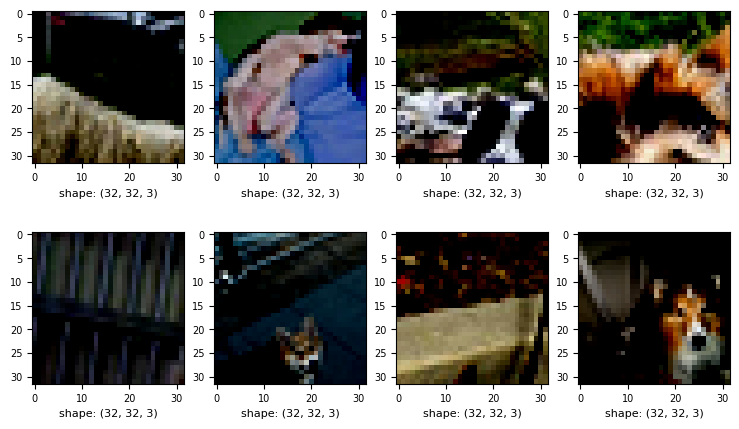

In [9]:
plt.figure(figsize=(9, 11))
for image in range(8):
    plt.subplot(4, 4, image + 1)
    plt.imshow((imagesIn[image]))
    plt.xlabel('shape: {}'.format(imagesIn[image].shape), fontsize = 8)
    plt.tick_params(labelsize = 7)

In [10]:
# create dataset to be used for training
BATCH_SIZE = 32
BUFFER_SIZE = 20000

imagesIn = tf.cast(imagesIn, 'float32')
df = tf.data.Dataset.from_tensor_slices(imagesIn).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(df)

<_BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None)>


# Step 3: Model Architecture

For this project, we will be generating dog images using a GAN architecture:

Generator: takes random noise as input and uses convolution and upsampling layers to transform the noise into a realistic image

Discriminator: receives images and uses convolutional layers with batch normalization and Leaky ReLU activations to distinguish between a real and fake images.

In [11]:
from tensorflow.keras import layers

WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

# Source: https://www.kaggle.com/code/cmalla94/dcgan-generating-dog-images-with-tensorflow/notebook

# MAKE DISCRIMINATOR
def make_generator():
    model = tf.keras.Sequential([
        # Dense layer with enough units to reshape into (8, 8, 256)
        tf.keras.layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(100,)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        
        # Reshape into (8, 8, 256)
        tf.keras.layers.Reshape((8, 8, 256)),
    ])
    
    # Print the output shape after the reshaping layer
    print("After reshape:", model.output_shape)  # (None, 8, 8, 256)

    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                              kernel_initializer=WEIGHT_INIT))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    # Print the output shape after the first Conv2DTranspose layer
    print("After first Conv2DTranspose:", model.output_shape)  # (None, 16, 16, 128)

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False,
                                              kernel_initializer=WEIGHT_INIT))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.5))

    # Print the output shape after the second Conv2DTranspose layer
    print("After second Conv2DTranspose:", model.output_shape)  # (None, 32, 32, 64)

    model.add(tf.keras.layers.Conv2DTranspose(3, (5, 5), strides=(1, 1), padding='same', use_bias=False,
                                              kernel_initializer=WEIGHT_INIT))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    # Print the final output shape
    print("Final output shape:", model.output_shape) # (None, 32, 32, 3)

    return model

In [12]:
# view summary
generator = make_generator()
print(generator.summary())

After reshape: (None, 8, 8, 256)
After first Conv2DTranspose: (None, 16, 16, 128)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


After second Conv2DTranspose: (None, 32, 32, 64)
Final output shape: (None, 32, 32, 3)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16384)          │     1,638,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16384)          │        65,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 16, 16, 128)    │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 32, 32, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │         4,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 3)      │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 32, 32, 3)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,733,516 (10.43 MB)

 Trainable params: 2,700,358 (10.30 MB)

 Non-trainable params: 33,158 (129.52 KB)

None


(1, 32, 32, 3)


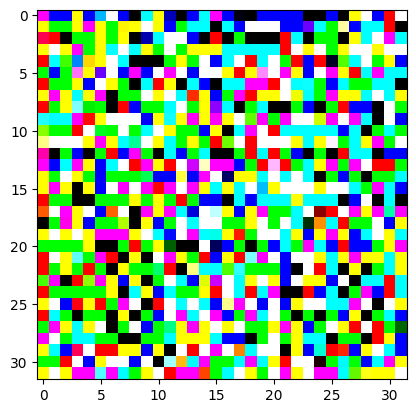

In [13]:
# random noise vector
noise = tf.random.normal([1,100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, :])
print(generated_image.shape)

In [14]:
import tensorflow as tf

WEIGHT_INIT = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.2)

# Source: https://www.kaggle.com/code/cmalla94/dcgan-generating-dog-images-with-tensorflow/notebook

def make_discriminator():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', 
                               input_shape=[img_size, img_size, 3],
                               kernel_initializer=WEIGHT_INIT),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),
    ])

    # Print the output shape after the first Conv2D layer
    print("After first Conv2D:", model.output_shape) 

    model.add(tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    # Print the output shape after the second Conv2D layer
    print("After second Conv2D:", model.output_shape) 

    model.add(tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', 
                                     kernel_initializer=WEIGHT_INIT))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    # Print the output shape after the third Conv2D layer
    print("After third Conv2D:", model.output_shape)

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Print the final output shape
    print("Final output shape:", model.output_shape)  # (None, 1)

    return model

In [15]:
# Build discriminator model
discriminator = make_discriminator()
discriminator.summary()

After first Conv2D: (None, 16, 16, 64)
After second Conv2D: (None, 8, 8, 128)
After third Conv2D: (None, 4, 4, 256)
Final output shape: (None, 1)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 128)      │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 664,769 (2.54 MB)

 Trainable params: 663,873 (2.53 MB)

 Non-trainable params: 896 (3.50 KB)

The next step is loss functions and optimizers as they are important for training neural networds by guiding parameter updates based on the modele's performance relative to training objectives. They facilitate learning and optimization.

In [16]:
# Reference: https://www.kaggle.com/code/cmalla94/dcgan-generating-dog-images-with-tensorflow

def smooth_positive_labels(y):
    return y - 0.3 + (np.random.random(y.shape) * 0.3)

def smooth_negative_labels(y):
    return y + np.random.random(y.shape) * 0.5

def noisy_labels(y, p_flip):
    # determine the number of labels to flip
    n_select = int(p_flip * y.shape[0].value)
    # choose labels to flip
    flip_ix = choice([i for i in range(y.shape[0].value)], size = n_select)
    # invert the labels in place
    y[flip_ix] = 1 - y[flip_ix]
    return y

In [17]:
# This method returns a helper function to compute cross entropy loss
# code from tf dcgan tutorial
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits = False)

# The Discriminator loss function
def discriminator_loss(real_output, fake_output):

    real_output_smooth = smooth_positive_labels(tf.ones_like(real_output))
    fake_output_smooth = smooth_negative_labels(tf.zeros_like(fake_output))
    real_loss = cross_entropy(real_output_smooth, real_output)
    fake_loss = cross_entropy(fake_output_smooth, fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# The Generator loss function
def generator_loss(fake_output):
    fake_output_smooth = smooth_negative_labels(tf.ones_like(fake_output))
    return cross_entropy(fake_output_smooth, fake_output)

# Adam
generator_optimizer = tf.keras.optimizers.Adam(learning_rate = .0002, beta_1 = .5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = .0002, beta_1 = .5)

In [18]:
# code from tf dcgan tutorial

EPOCHS = 5
noise_dim = 100
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train_step(images, G_loss_list, D_loss_list):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)      
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
    G_loss_list.append(gen_loss.numpy())
    D_loss_list.append(disc_loss.numpy())
    # Taking the derivatives and applying gradients using Adam optimizer
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    

In [19]:
# Train function
def train(dataset, epochs):
    G_loss = []
    D_loss = []
    for epoch in range(epochs):
        start = time.time()
        for image_batch in dataset:
            train_step(image_batch, G_loss, D_loss)
            
        plot_loss(G_loss, D_loss, epoch)
        G_loss = []
        D_loss = []
        if (epoch % 10 == 0):
            display.clear_output(wait = True)
            generate_and_save_images(generator, epoch + 1, seed)
            
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))
        
    # Generate after the final epoch
    print("Final Epoch")
    generate_and_save_images(generator, epochs, seed)

In [20]:
import time
def generate_and_save_images(model, epoch, test_input):
    # Training = Fasle so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training = False)    
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((predictions[i, :, :, :] + 1.) / 2.)
        plt.axis('off')
    plt.show()

In [21]:
# reference: https://www.kaggle.com/code/jesucristo/introducing-dcgan-dogs-images
def plot_loss (G_losses, D_losses, epoch):
    plt.figure(figsize=(8,4))
    plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch + 1))
    plt.plot(G_losses,label="G")
    plt.plot(D_losses,label="D")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# Step 4: Results and Analysis

In this section, we will be viewing the results of our model.

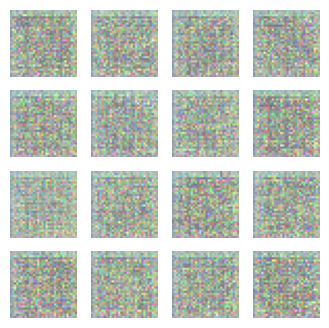

Time for epoch 1 is 393.5913097858429 sec


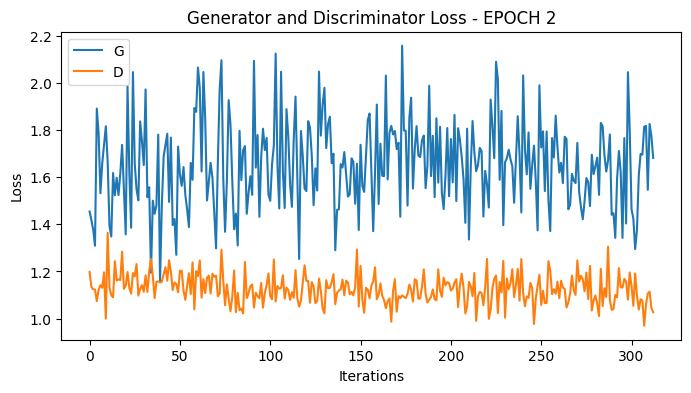

Time for epoch 2 is 442.25283646583557 sec


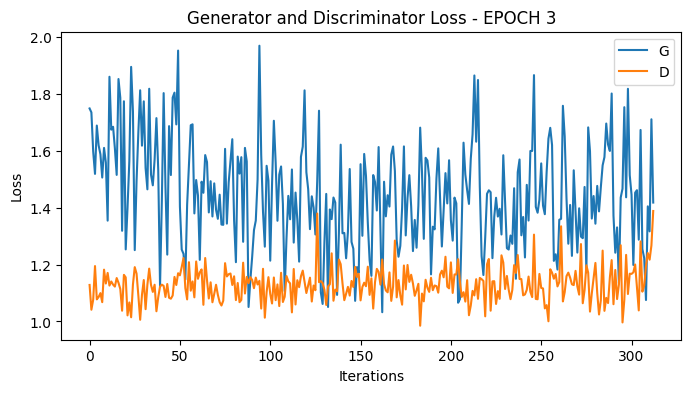

Time for epoch 3 is 386.12806367874146 sec


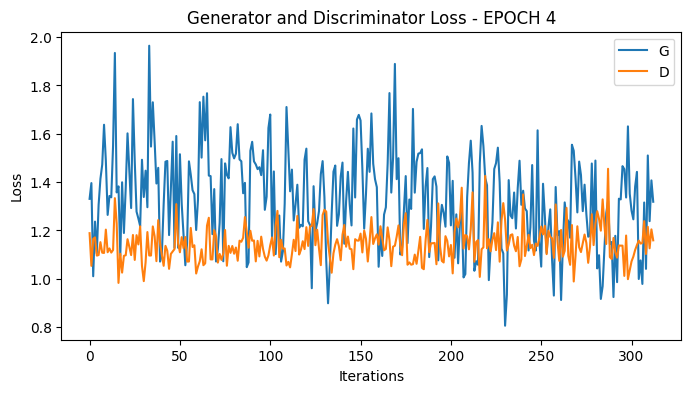

Time for epoch 4 is 385.27307200431824 sec


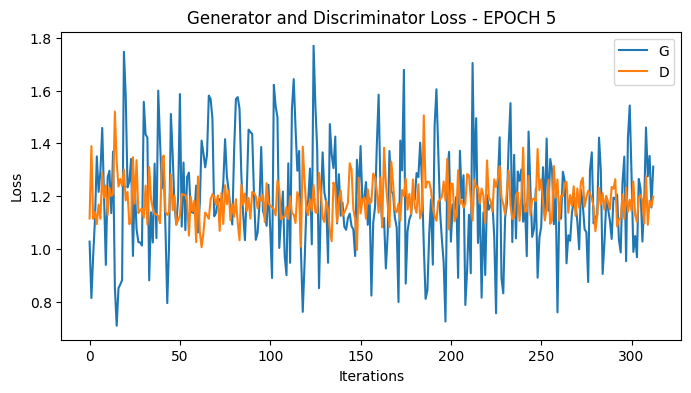

Time for epoch 5 is 385.92171025276184 sec
Final Epoch


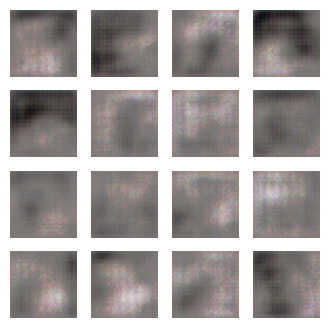

In [22]:
print('Starting training')
train(df, EPOCHS)

In [23]:
%%time

# save images
# reference: https://www.kaggle.com/code/cmalla94/dcgan-generating-dog-images-with-tensorflow

z = zipfile.PyZipFile('images.zip', mode='w')

filename = 'gen_model.h5'
tf.keras.models.save_model(
    generator, filename, overwrite = True, include_optimizer = True, save_format = None)

for k in range(10000):
    generated_image = generator(tf.random.normal([1, noise_dim]), training = False)
    f = str(k) + '.png'
    img = ((generated_image[0, :, :, :] + 1.) / 2.).numpy()
    tf.keras.preprocessing.image.save_img(f, img, scale = True)
    z.write(f) 
    os.remove(f)
z.close()

CPU times: user 4min 49s, sys: 7.47 s, total: 4min 57s
Wall time: 3min 47s


In [24]:
FileLinks('.')

./
  images.zip
  gen_model.h5

# Step 5: Conclusion

In conclusion, we build a discriminator and generator to train the dog images and see if realistic images can be generated. The end result is not a successful generation but that is because the number of epochs is quite low (5). I believe the whole model can be improved drastically but since 5 epochs take a long time, it would take a very long time to run something greater than 100 epochs. Additionally, I can also increase the size of images going into the models. Initially, my image size was (64, 64, 3) but that was taking a very long time to train so I reduced the image size to (32, 32, 3) which helped speed up the training time.